# 1D Spectrum Analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord,Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling import Datasets
from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    
)

from gammapy.spectrum import (
    SpectrumDatasetMaker,
    SpectrumDatasetOnOff,
    SpectrumDataset,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__


'0.15'

In [2]:
from pathlib import Path

path = Path("../../../../gammapy_data/GC_variability2020/hap-hd/mapdatasets/mapdatasets1D")
path.mkdir(exist_ok=True)

# Collecting data and sorting observations

In [3]:
data_store_hess1 = DataStore.from_dir("$GAMMAPY_DATA/hap-hd_Prod05/hess1/std_ImPACT_fullEnclosure")
data_store_hess1u = DataStore.from_dir("$GAMMAPY_DATA/hap-hd_Prod05/hess1u/std_ImPACT_fullEnclosure")
data_store_hess2 = DataStore.from_dir("$GAMMAPY_DATA/hap-hd_Prod05/hess2/std_ImPACT_fullEnclosure")

In [4]:
# Sky region selection : observation pointing within this region will be selected 
#(this can be redundant with maximum offset selection, but using the max_offset should be prefered)

from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(2, 'deg'),
                 border=Angle(0, 'deg'))


# selecting the admitted range of zenithal angle, such selection can be done for any column of the obs_table
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=[0., 90])

obs_table1 = data_store_hess1.obs_table.select_observations(selection)
obs_table1 = obs_table1.select_observations(selectionZEN)

obs_table1u = data_store_hess1u.obs_table.select_observations(selection)
obs_table1u = obs_table1u.select_observations(selectionZEN)

obs_table2 = data_store_hess2.obs_table.select_observations(selection)
obs_table2 = obs_table2.select_observations(selectionZEN)

In [5]:
# Removing observations lacking IRFs (effective area, energy dispersion, point spread function and background model)


#HESS1
ids = obs_table1["OBS_ID"].tolist()
observations1 = data_store_hess1.get_observations(ids, skip_missing=True)

for obs in observations1:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations1 = data_store_hess1.get_observations(ids, skip_missing=True)
obs_table1 = obs_table1.select_obs_id(ids)


#HESS1U
ids = obs_table1u["OBS_ID"].tolist()
observations1u = data_store_hess1u.get_observations(ids, skip_missing=True)

for obs in observations1u:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations1u = data_store_hess1u.get_observations(ids, skip_missing=True)
obs_table1u = obs_table1u.select_obs_id(ids)


# HESS2
ids = obs_table2["OBS_ID"].tolist()
observations2 = data_store_hess2.get_observations(ids, skip_missing=True)

for obs in observations2:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg
            
    except:
        ids.remove(obs.obs_id)
        print("Removed observations : " + str(obs.obs_id))
        
observations2 = data_store_hess2.get_observations(ids, skip_missing=True)
obs_table2 = obs_table2.select_obs_id(ids)

Removed observations : 20191
Removed observations : 27162
Removed observations : 27204
Removed observations : 27329
Removed observations : 27578
Removed observations : 27607
Removed observations : 27638
Removed observations : 146924
Removed observations : 146965
Removed observations : 147004
Removed observations : 153153


In [6]:
#time intervals used for selection

t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

In [7]:
year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

# HESS1
yearly_obs1 = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table1.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store_hess1.get_observations(ids, skip_missing=True)
    yearly_obs1[year] = observations_year

#HESS1U    
yearly_obs1u = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table1u.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store_hess1u.get_observations(ids, skip_missing=True)
    yearly_obs1u[year] = observations_year

#HESS2    
yearly_obs2 = dict()

for year in range(2004,2020) :
    
    obs_table_year = obs_table2.select_observations(year_intervals[year])
    ids = obs_table_year["OBS_ID"].tolist()
    observations_year = data_store_hess2.get_observations(ids, skip_missing=True)
    yearly_obs2[year] = observations_year

## Setting the parameters of the analysis

In [8]:
# Defining the "on" region over which the spectrum will be computed

on_region_radius = Angle("0.1 deg")
on_region = CircleSkyRegion(center=src_pos, radius=on_region_radius)

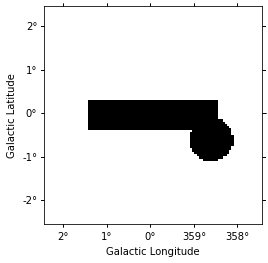

In [9]:
# We need to define an "off" region as well, to estimate the background level

exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 0.7*u.deg) #réduire en latitude
skydir = src_pos.galactic

# à rajouter au masque
bizarre_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)


exclusion_mask = Map.create(
    npix=(100, 100), binsz=0.05, skydir=skydir, proj="TAN", coordsys="GAL"
)

mask = exclusion_mask.geom.region_mask([exclusion_region], inside=False)*exclusion_mask.geom.region_mask([bizarre_region] , inside=False)
exclusion_mask.data = mask
exclusion_mask.plot();

In [10]:
e_reco = np.logspace(-1, np.log10(40), 20) * u.TeV

e_true = np.logspace(np.log10(0.05) ,np.log10(200) , 100) * u.TeV


dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "aeff", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

## Constructing the datasets

In [15]:
%%time

# constructing datasets for every stage of HESS (1,2,1U)
# constructing a dataset encompassing all 15 years of observations

datasets = []
datasetsHESS1 = []

for obs in observations1:
        dataset = dataset_maker.run(dataset_empty, obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        datasetsHESS1.append(dataset_on_off)
        datasets.append(dataset_on_off)
        
datasetsHESS2 = []

for obs in observations2:
        dataset = dataset_maker.run(dataset_empty, obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        datasetsHESS2.append(dataset_on_off)
        datasets.append(dataset_on_off)
        
datasetsHESS1U = []

for obs in observations1u:
        dataset = dataset_maker.run(dataset_empty, obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        datasetsHESS1U.append(dataset_on_off)
        datasets.append(dataset_on_off)

CPU times: user 9min 9s, sys: 2.16 s, total: 9min 11s
Wall time: 9min 11s


In [ ]:
# not saving, too complicated
filename = "dataset_tot.fits.gz"
datasets.write(path/filename, overwrite=True)

In [ ]:
# No

filename = "dataset_HESS1.fits.gz"
datasetsHESS1.write(path/filename, overwrite=True)

filename = "dataset_HESS2.fits.gz"
datasetsHESS2.write(path/filename, overwrite=True)

filename = "dataset_HESS1U.fits.gz"
datasetsHESS1U.write(path/filename, overwrite=True)

In [12]:
%%time

# constructing datasets for every year of observations

year_datasets = dict()

for year in range(2004,2020):
    for obs in yearly_obs1[year]:
        dataset = dataset_maker.run(dataset_empty, obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        year_datasets[year].append(dataset_on_off)
        
    for obs in yearly_obs2[year]:
        dataset = dataset_maker.run(dataset_empty, obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        year_datasets[year].append(dataset_on_off)
        
    for obs in yearly_obs1u[year]:
        dataset = dataset_maker.run(dataset_empty, obs)
        dataset_on_off = bkg_maker.run(dataset, obs)
        dataset_on_off = safe_mask_masker.run(dataset_on_off, obs)
        year_datasets[year].append(dataset_on_off)

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/regions/shapes/circle.py:74: RuntimeWarning: invalid value encountered in less
  in_circle = self.center.separation(pixcoord) < self.radius


KeyError: 2004

In [ ]:
# No
for year in range(2004,2020):
    filename = "dataset"+str(year)+".fits.gz"
    year_datasets[year].write(path/filename, overwrite=True)

# Analysis

In [26]:
# Some datasets don't have any off counts, we need to remove those to proceed

dataclean = []
for dataset in datasets:
    if dataset.counts_off != None:
        res +=1
        dataclean.append(dataset)

In [37]:
res = 0
for dataset in dataclean:
    if dataset.counts_off == None:
        res +=1
print(res)

0


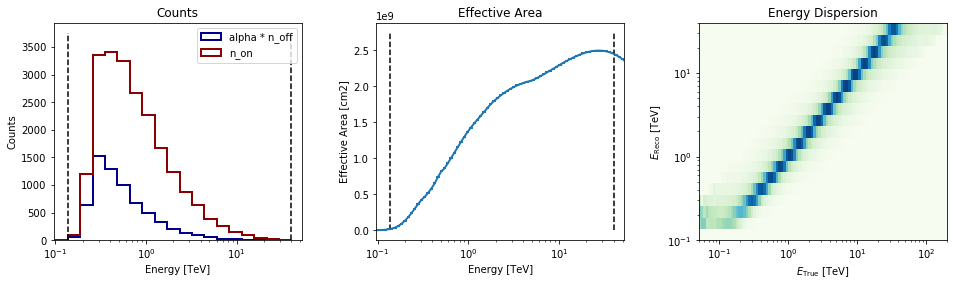

In [38]:
datasets_stacked = Datasets(dataclean).stack_reduce()
datasets_stacked.peek()

## Fitting without stacking

In [18]:
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV , lambda_= 1/(5*u.TeV) , alpha= 1
)
model_joint = SkyModel(spectral_model=spectral_model)


In [20]:
maskfit = datasets[0].counts.energy_mask(0.7*u.TeV, 100*u.TeV)

for dataset in dataclean:
    dataset.models = model_joint
    dataset.mask_fit = maskfit

fit_joint = Fit(dataclean)
result_joint = fit_joint.run()

# we make a copy here to compare it later
model_best_joint = model_joint.copy()
model_best_joint.spectral_model.parameters.covariance = (
    result_joint.parameters.covariance
)

## Fitting after stacking

In [36]:
model_stack = SkyModel(spectral_model=spectral_model)

maskfit = datasets_stacked.counts.energy_mask(0.7*u.TeV, 100*u.TeV)

datasets_stacked.model = model_stack
datasets_stacked.mask_fit = maskfit

stacked_fit = Fit([datasets_stacked])
result_stacked = stacked_fit.run()

# make a copy to compare later
model_best_stacked = model_stack.copy()

TypeError: 'NoneType' object is not iterable

In [32]:
datasets_stacked.model

SkyModel(spatial_model=None, spectral_model=<gammapy.modeling.models.spectral.ExpCutoffPowerLawSpectralModel object at 0x7fd9037b3048>)

In [33]:
# problème result_stacked.parameters.covariance n'a pas la bonne taille
model_best_stacked.spectral_model.parameters.covariance = (
    result_stacked.parameters.covariance
)

NameError: name 'result_stacked' is not defined

## Comparing the two fits

In [34]:
model_best_joint.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
index,1.844e+00,5.806e-02,,nan,nan,False
amplitude,2.592e-12,5.975e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lambda_,1.665e-01,1.766e-02,TeV-1,nan,nan,False
alpha,1.000e+00,0.000e+00,,nan,nan,True


In [35]:
model_best_stacked.parameters.to_table()

NameError: name 'model_best_stacked' is not defined

In [ ]:
plt.figure(figsize=(10,10))
plot_kwargs = {
    "energy_range": [0.1, 30] * u.TeV,
    "energy_power": 2,
    "flux_unit": "erg-1 cm-2 s-1",
}

# plot stacked model
model_best_stacked.spectral_model.plot(
    **plot_kwargs, label="Stacked analysis result"
)
#model_best_stacked.spectral_model.plot_error(**plot_kwargs)

# plot joint model
model_best_joint.spectral_model.plot(
    **plot_kwargs, label="Joint analysis result", ls="--"
)
model_best_joint.spectral_model.plot_error(**plot_kwargs)

plt.legend()

In [ ]:
plt.figure(figsize=(9, 7))
ax_spectrum, ax_residual = datasets_stacked.plot_fit()
#ax_spectrum.set_ylim(0.1, 40)

In [ ]:
datasets_stacked.plot_residuals(method='diff/sqrt(model)'')

## Computing Flux points

In [ ]:
e_min, e_max = 0.7, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [ ]:
fpe = FluxPointsEstimator(datasets=copy, e_edges=e_edges)
flux_points = fpe.run()

In [ ]:

plt.figure(figsize=(8, 5))
flux_points.table["is_ul"] = flux_points.table["ts"] < 4
ax = flux_points.plot(
    energy_power=2, flux_unit="erg-1 cm-2 s-1", color="darkorange"
)
flux_points.to_sed_type("e2dnde").plot_ts_profiles(ax=ax)



In [ ]:
flux_points_dataset = FluxPointsDataset(
    data=flux_points, models=model_best_joint
)

In [ ]:
plt.figure(figsize=(8, 6))
flux_points_dataset.peek();